# <a id='toc1_'></a>[Model Evaluation](#toc0_)

This notebook contains the code to evaluate the models on the test set.

**Table of contents**<a id='toc0_'></a>    
- [Model Evaluation](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [Prepare data for training](#toc4_)    
  - [Neural network data](#toc4_1_)    
  - [Linear model data](#toc4_2_)    
- [Train Neural Network](#toc5_)    
- [Train linear models](#toc6_)    
  - [OLS](#toc6_1_)    
  - [LASSO](#toc6_2_)    
- [Summarize the results](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

from libs.models import *
from libs.functions import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

%load_ext autoreload
%autoreload 2

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
# read data
df = pd.read_csv('data/data.csv')

# <a id='toc4_'></a>[Prepare data for training](#toc0_)

In [3]:
# prepare expanding window splits
periods = {
    '21' : '2020-01-01', # 2021 is the test set
    '22' : '2021-01-01', # 2022 is the test set
    '23' : '2022-01-01', # 2023 is the test set
    '24': '2023-01-01' # 2024 is the test set
}

# identify dummy vs. numeric columns
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
nace_cols = [c for c in feature_cols if c.startswith('NACE_')]
dummy_cols = ['divi','divo'] # sin removed
macro_cols = ['discount', 'tms', 'dp', 'ep', 'svar'] # 'bm_macro'

# nummeric cols = cols not in cat and macro cols
numeric_cols = [c for c in feature_cols if c not in dummy_cols and c not in nace_cols and c not in macro_cols]

# feature_cols = numeric_cols + dummy_cols + nace_cols # reorder columns to have numeric first

df_raw = df.copy(deep=True)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

# drop data from 2025
df_raw = df_raw[df_raw['timestamp'] < '2025-01-01']

In [4]:
C = df[numeric_cols].values         # shape = (n_rows, P_c)
X = df[macro_cols].values           # shape = (n_rows, P_x)

# 1) compute all pairwise products with broadcasting:
#    this gives shape (n_rows, P_c, P_x)
K = C[:,:,None] * X[:,None,:]

# 2) reshape to (n_rows, P_c * P_x)
Z = K.reshape(len(df), -1)

# 3) build the column names in the same order
xc_names = [
    f"{c}_x_{m}"
    for c in numeric_cols
    for m in macro_cols
]

# 4) wrap back into a DataFrame
df_xc = pd.DataFrame(Z, columns=xc_names, index=df.index)

feature_cols = numeric_cols + xc_names + dummy_cols + nace_cols
numeric_cols = numeric_cols + xc_names
cat_cols = dummy_cols + nace_cols
df_z = df_raw.merge(df_xc, left_index=True, right_index=True)
# drop macro_cols
df_z = df_z.drop(columns=macro_cols)
# sort columns by feature_cols
df_norm = df_z[['timestamp', 'ticker', 'target'] + feature_cols]

y_values = df_norm['target'].values.astype('float32')


## <a id='toc4_1_'></a>[Neural network data](#toc0_)
Including a validation set

In [5]:
# prepare containers
X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}
y_scalers = {}

for y, period in periods.items():
    period = pd.to_datetime(period)

    # split masks
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract raw feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, val, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_va_df[numeric_cols] = X_va_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)


    # now fit scaler on numeric only
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough',  cat_cols)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors[y] = preprocessor

    # transform all splits
    X_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    X_val[y]   = preprocessor.transform(X_va_df).astype('float32')
    X_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # fit standard scaler on y values
    y_scaler = StandardScaler()
    y_scaler.fit(y_tr.reshape(-1, 1))
    y_scalers[y] = y_scaler
    y_tr = y_scaler.transform(y_tr.reshape(-1, 1)).flatten()
    y_va = y_scaler.transform(y_va.reshape(-1, 1)).flatten()
    y_te = y_scaler.transform(y_te.reshape(-1, 1)).flatten()


    # store targets as before
    y_train[y] = y_tr.reshape(-1, 1)
    y_val[y]   = y_va.reshape(-1, 1)
    y_test[y]  = y_te.reshape(-1, 1)


## <a id='toc4_2_'></a>[Linear model data](#toc0_)
Excluding the validation set

In [6]:

Xlin_train, Xlin_test = {}, {}
ylin_train, ylin_test = {}, {}
preprocessors_lin = {}

cat_cols_lin = cat_cols + ['const']
feature_cols_lin = feature_cols + ['const']

for y, period in periods.items():
    period = pd.to_datetime(period)
    tr_mask = df_norm['timestamp']- pd.DateOffset(years=1) < period
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols]
    X_te_df = df_norm.loc[te_mask, feature_cols]
    y_tr = y_values[tr_mask]
    y_te = y_values[te_mask]

    # add constant column for linear regression
    X_tr_df['const'] = 1
    X_te_df['const'] = 1

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)

    # fit scaler only on training set
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough', cat_cols_lin)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors_lin[y] = preprocessor

    # ttransform splits
    Xlin_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    Xlin_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # targets
    ylin_train[y] = y_tr
    ylin_test[y]  = y_te

# <a id='toc5_'></a>[Train Neural Network](#toc0_)

## Constant width

In [7]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
hidden_depth = 4 # only hidden, excluding in- and output layers
hidden_width = 16 # int for all being equal width; list for different widths
learning_rate = 1e-4
activation_fun = nn.ReLU # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 1e-5 # 1e-3 # l1 regularization
lambda_l2 = 1e-4 # 1e-4 # l2 regularization
dropout = 0.0

# general parmeters
patience = 25
print_freq = 250
epochs = 250
batch_size = 4096

n_runs = 5 # number of runs for each model to average over


Using device: mps


In [8]:
best_models = {}
history   = {}
mlp_pred  = {}

for y, period in periods.items():
    print(f"\n=== Year {y}: running {n_runs} restarts ===")
    all_run_preds = []

    for run in range(n_runs):
        # set random seed for reproducibility (change for each run)
        seed = 42 + run
        np.random.seed(seed)
        torch.manual_seed(seed)
        print(f"Run {run+1}/{n_runs}, seed={seed}")

        # instantiate a fresh model & optimizer
        input_dim = X_train[y].shape[1]
        model = MLPModel(input_dim,
                         depth=hidden_depth,
                         width=hidden_width,
                         dropout=dropout,
                         activation=activation_fun).to(device)
        optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate)


        # wrap datasets
        train_ds = MLPdataset(X_train[y], y_train[y])
        val_ds   = MLPdataset(X_val[y],   y_val[y])

        # train
        trained_model, hist = train_mlp(train_ds,
                                        val_ds,
                                        model,
                                        criterion,
                                        epochs,
                                        patience,
                                        print_freq,
                                        device,
                                        optimizer=optimizer,
                                        lambda_l1=lambda_l1,
                                        lambda_l2=lambda_l2,
                                        batch_size=batch_size,
                                        shuffle_train=True,
                                        shuffle_val=False,
                                        save_path=f'models/mlp_y{y}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                        )

        # predict on test set
        preds = predict_mlp(trained_model,
                            X_test[y],
                            y_test=y_test[y],
                            scaler= y_scalers[y], # preprocessors[y] if hasattr(preprocessors[y], 'inverse_transform') else None,
                            batch_size=batch_size,
                            device=device)
        all_run_preds.append(preds)

        # optionally store the last run’s model & history
        best_models[(y, run)] = trained_model
        history[(y, run)]     = hist

    # stack (n_runs, n_samples) average over axis=0
    all_run_preds = np.stack(all_run_preds, axis=0)
    mlp_pred[y]   = np.mean(all_run_preds, axis=0)

    print(f"Averaged predictions for year {y} computed.")


=== Year 21: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 34
Best val loss: 7.67487E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run1.pth
Run 2/5, seed=43
Early stopping at epoch 170
Best val loss: 7.60042E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run2.pth
Run 3/5, seed=44
Early stopping at epoch 27
Best val loss: 7.66600E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run3.pth
Run 4/5, seed=45
Early stopping at epoch 177
Best val loss: 7.46799E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run4.pth
Run 5/5, seed=46
Early stopping at epoch 164
Best val loss: 7.65523E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run5.pth
Averaged predictions for year 21 computed.

=== Year 22: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 37
Best val loss: 4.73750E-01
Model saved to models/mlp_y22_l11e-05_l20.0001_drop0.0

## Pyramid

In [9]:
# training model with most data on multiple parameters
hidden_depth_pyr = None
hidden_width_pyr = [32, 16, 8] #[32, 16, 8, 4], 

In [10]:
best_models_pyr = {}
history_pyr   = {}
mlp_pred_pyr  = {}

for y, period in periods.items():
    print(f"\n=== Year {y}: running {n_runs} restarts ===")
    all_run_preds = []

    for run in range(n_runs):
        # set random seed for reproducibility (change for each run)
        seed = 42 + run
        np.random.seed(seed)
        torch.manual_seed(seed)
        print(f"Run {run+1}/{n_runs}, seed={seed}")

        # instantiate a fresh model & optimizer
        input_dim = X_train[y].shape[1]
        model = MLPModel(input_dim,
                         depth=len(hidden_width_pyr),
                         width=hidden_width_pyr,
                         dropout=dropout,
                         activation=activation_fun).to(device)
        optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate)


        # wrap datasets
        train_ds = MLPdataset(X_train[y], y_train[y])
        val_ds   = MLPdataset(X_val[y],   y_val[y])

        # train
        trained_model, hist = train_mlp(train_ds,
                                        val_ds,
                                        model,
                                        criterion,
                                        epochs,
                                        patience,
                                        print_freq,
                                        device,
                                        optimizer=optimizer,
                                        lambda_l1=lambda_l1,
                                        lambda_l2=lambda_l2,
                                        batch_size=batch_size,
                                        shuffle_train=True,
                                        shuffle_val=False,
                                        save_path=f'models/mlp_y{y}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                        )

        # predict on test set
        preds = predict_mlp(trained_model,
                            X_test[y],
                            y_test=y_test[y],
                            scaler= y_scalers[y], # preprocessors[y] if hasattr(preprocessors[y], 'inverse_transform') else None,
                            batch_size=batch_size,
                            device=device)
        all_run_preds.append(preds)

        # optionally store the last run’s model & history
        best_models_pyr[(y, run)] = trained_model
        history_pyr[(y, run)]     = hist

    # stack (n_runs, n_samples) average over axis=0
    all_run_preds = np.stack(all_run_preds, axis=0)
    mlp_pred_pyr[y]   = np.mean(all_run_preds, axis=0)

    print(f"Averaged predictions for year {y} computed.")


=== Year 21: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 164
Best val loss: 7.62579E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run1.pth
Run 2/5, seed=43
Early stopping at epoch 161
Best val loss: 7.59860E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run2.pth
Run 3/5, seed=44
Early stopping at epoch 34
Best val loss: 7.67148E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run3.pth
Run 4/5, seed=45
Early stopping at epoch 201
Best val loss: 7.64978E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run4.pth
Run 5/5, seed=46
Early stopping at epoch 42
Best val loss: 7.65079E-01
Model saved to models/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run5.pth
Averaged predictions for year 21 computed.

=== Year 22: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 76
Best val loss: 4.68042E-01
Model saved to models/mlp_y22_l11e-05_l20.0001_drop0.0

# <a id='toc6_'></a>[Train linear models](#toc0_)

## <a id='toc6_1_'></a>[OLS](#toc0_)

In [13]:
# linear model
# estimate the parameters
ols_est = {}
ols_pred = {}
ols_coeffs = {}


for y in periods.keys():
    print(f"Estimating OLS for {y}...")
    x_tr = Xlin_train[y]
    y_tr = ylin_train[y]
    x_te = Xlin_test[y]
    y_te = ylin_test[y]


    # estimate the parameters
    ols_est[y] = estimate(y_tr, x_tr)
    # ols_pred_train[y] = ols_est[y]['b_hat'] @ x_tr.T
    ols_pred[y] = ols_est[y]['b_hat'] @ x_te.T
    ols_coeffs[y] = ols_est[y]['b_hat']

Estimating OLS for 21...


/Users/johan/Documents/04 Uni/10 Thesis/git/MastersThesis/libs/functions.py:194: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov)).reshape(-1, 1)


Estimating OLS for 22...
Estimating OLS for 23...
Estimating OLS for 24...


In [14]:
ols_coeffs_df = pd.DataFrame(ols_coeffs, index=feature_cols_lin)
ols_coeffs_df = ols_coeffs_df.reindex(ols_coeffs_df.abs().sum(axis=1).sort_values(ascending=False).index, axis=0)
ols_coeffs_df = ols_coeffs_df.T
display(ols_coeffs_df)

,roic_x_tms,roaq_x_tms,roic_x_dp,roaq_x_dp,roic_x_svar,roaq_x_svar,roaq_x_discount,roic_x_discount,roaq_x_ep,roic_x_ep,...,cashpr_x_svar,lev_x_discount,ill_x_dp,turn_x_tms,pchgm_pchsale_x_discount,pctacc_x_dp,std_turn_x_discount,cashdebt_x_tms,salecash_x_dp,rd_sale_x_svar
21,-0.506179,0.511313,0.294592,-0.286156,0.797362,-0.797641,-0.134628,0.131583,-0.315503,0.407231,...,-0.000562,0.000103,-0.000107,0.000454,0.001054,0.000423,0.000326,-0.000426,-0.000517,-0.000433
22,-0.551004,0.548916,0.993486,-0.990598,-0.177860,0.178388,-0.177591,0.176125,-0.282070,0.318052,...,-0.001314,0.000694,-0.001100,0.000153,-0.000011,0.000763,0.000121,-0.000573,-0.000382,0.000059
23,1.764620,-1.768156,-2.346369,2.352144,-0.485175,0.482774,-0.219153,0.217865,0.051667,0.086960,...,-0.000564,0.001367,0.000375,-0.000221,0.000564,0.000505,0.000659,0.000201,0.000086,-0.000173
24,-2.107210,2.099086,0.302022,-0.298068,2.135682,-2.129545,2.916310,-2.908984,2.156285,-1.949453,...,-0.000469,0.000346,0.000848,-0.001581,0.000779,0.000264,-0.000595,0.000075,-0.000030,0.000285


## <a id='toc6_2_'></a>[LASSO](#toc0_)

In [15]:
# linear model
# create a grid using numpy.geomspace
penalty_grid = np.geomspace(1e-7, 100, num = 1000)
lasso_est = {}
# lasso_pred_train = {}
lasso_pred = {}
lasso_coeffs = {}


with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    for y in periods.keys():
        print(f"Estimating LASSO for {y}...")
        x_tr = Xlin_train[y]
        y_tr = ylin_train[y]
        x_te = Xlin_test[y]
        y_te = ylin_test[y]

        # estimate the model using LassoCV
        fit_CV = LassoCV(cv=5, alphas=penalty_grid, max_iter=1000, eps=1e-3, n_jobs=-1).fit(x_tr,y_tr)
        # lasso_pred_train[y] = fit_CV.predict(x_tr)
        lasso_pred[y] = fit_CV.predict(x_te)

        # store the coefficients
        coeff = fit_CV.coef_
        lasso_coeffs[y] = coeff


Estimating LASSO for 21...
Estimating LASSO for 22...
Estimating LASSO for 23...
Estimating LASSO for 24...


In [16]:
lasso_coeffs_df = pd.DataFrame(lasso_coeffs, index=feature_cols_lin)
# sort by absolute value
lasso_coeffs_df = lasso_coeffs_df.reindex(lasso_coeffs_df.abs().sum(axis=1).sort_values(ascending=False).index, axis=0)

# drop columns with all zeros
lasso_coeffs_df = lasso_coeffs_df.T
lasso_coeffs_df = lasso_coeffs_df.loc[:, (lasso_coeffs_df != 0).any(axis=0)]
display(lasso_coeffs_df)

,indmom_x_discount,mom12m,age_x_discount,retvol_x_dp,age_x_dp,age_x_svar,indmom_x_svar,cfp_ia_x_discount,mom1m_x_discount,saleinv_x_svar,...,turn_x_discount,pchsale_pchinvt_x_dp,rd_x_tms,chatoia_x_svar,std_turn_x_tms,invest_x_svar,pricedelay_x_tms,acc_x_tms,mom12m_x_svar,dy_x_svar
21,0.011941,0.008003,-0.011049,0.004804,-0.005509,0.005513,-0.005822,0.003619,0.003745,0.003560,...,-0.000176,-0.000000,-0.000097,0.000151,-0.000046,-0.000115,0.000000,-0.00000,-0.000000,0.000000
22,0.011855,0.008319,-0.011579,0.005688,-0.004986,0.005956,-0.005752,0.003973,0.003462,0.003766,...,-0.000130,-0.000121,-0.000016,0.000077,-0.000045,-0.000000,0.000000,-0.00000,-0.000000,0.000000
23,0.010299,0.007802,-0.006855,0.006583,-0.003968,0.004533,-0.004049,0.004941,0.003819,0.003208,...,-0.000000,-0.000000,-0.000000,0.000000,-0.000136,-0.000000,0.000094,-0.00000,-0.000000,0.000004
24,0.009636,0.007448,-0.000604,0.006724,-0.005943,0.004270,-0.003508,0.005565,0.004731,0.003292,...,-0.000000,-0.000180,-0.000185,0.000000,-0.000000,-0.000000,0.000000,-0.00007,-0.000064,0.000000


# <a id='toc7_'></a>[Summarize the results](#toc0_)

In [17]:
pred_dfs = []

for y, period in periods.items():
    # rebuild masks
    te_mask = ((df_norm['timestamp'] - pd.DateOffset(years=1) >= period) &
               (df_norm['timestamp'] - pd.DateOffset(years=2) <  period))
    X_te_df = df_norm.loc[te_mask, feature_cols]
    idx = X_te_df.index


    pred_dfs.append(pd.DataFrame({
        'period':    y,
        'timestamp': df_norm.loc[idx, 'timestamp'],
        'ticker':    df_norm.loc[idx, 'ticker'],
        'y_true':    df_norm.loc[idx, 'target'].values.astype('float32'),
        'discount':  df.loc[idx, 'discount'].values.astype('float32'),
        'OLS':    ols_pred[y].flatten(),
        'LASSO':  lasso_pred[y],
        'MLP':    mlp_pred[y],
        'MLP-Pyr': mlp_pred_pyr[y],
    }, index=idx))

all_preds = pd.concat(pred_dfs).sort_index()

# create full return numbers
all_preds['discount_month'] = (1 + all_preds['discount'])**(1/12)-1
all_preds['y_true_full'] = all_preds['y_true'] + all_preds['discount_month']
all_preds['OLS_full'] = all_preds['OLS'] + all_preds['discount_month']
all_preds['LASSO_full'] = all_preds['LASSO'] + all_preds['discount_month']
all_preds['MLP_full'] = all_preds['MLP'] + all_preds['discount_month']
all_preds['MLP-Pyr_full'] = all_preds['MLP-Pyr'] + all_preds['discount_month']

# save predictions
all_preds.to_csv('data/predictions.csv', index=False)

In [24]:
metrics_full = {}
results_full = {}
methods = ['OLS', 
           'LASSO', 
           'MLP',
           'MLP-Pyr',
           ]
for method in methods:
    for y, period in periods.items():
        y_true = all_preds.loc[all_preds['period'] == y, 'y_true']
        y_pred = all_preds.loc[all_preds['period'] == y, method]
        y_true_full = all_preds.loc[all_preds['period'] == y, f'y_true_full']
        y_pred_full = all_preds.loc[all_preds['period'] == y, f'{method}_full']
        key = f'{method}{y}'
        results_full[key] = {
            'RMSE': rmse_fun(y_pred, y_true),
            'MAE': mae_fun(y_pred, y_true),
            # 'MADL': madl_fun(y_pred_full, y_true_full),
            'AMADL': amadl_fun(y_pred_full, y_true_full, delta=0.5)
        }
    key = f'{method}Total'
    results_full[key] = {
        'RMSE': rmse_fun(all_preds[method], all_preds['y_true']),
        'MAE': mae_fun(all_preds[method], all_preds['y_true']),
        # 'MADL': madl_fun(all_preds[f'{method}_full'], all_preds['y_true_full']),
        'AMADL' : amadl_fun(all_preds[f'{method}_full'], all_preds['y_true_full'], delta=0.5)
    }
    
for y in list(periods.keys()) + ['Total']:
    if y != 'Total':
        name = '20' + y
    else:
        name = y
    for metric in ['RMSE',
                   'MAE',
                #    'MADL',
                   'AMADL']:
        key = f'*{metric}*{name}'
        vals = [
            results_full[f'OLS{y}'][metric],
            results_full[f'LASSO{y}'][metric],
            results_full[f'MLP{y}'][metric],
            results_full[f'MLP-Pyr{y}'][metric],
        ]
        metrics_full[key] = vals

tab_full = latex_table_grouped(methods,metrics_full)

with open('tabs/prediction_results.tex', 'w') as f:
    f.write(tab_full)
# print(tab_full)


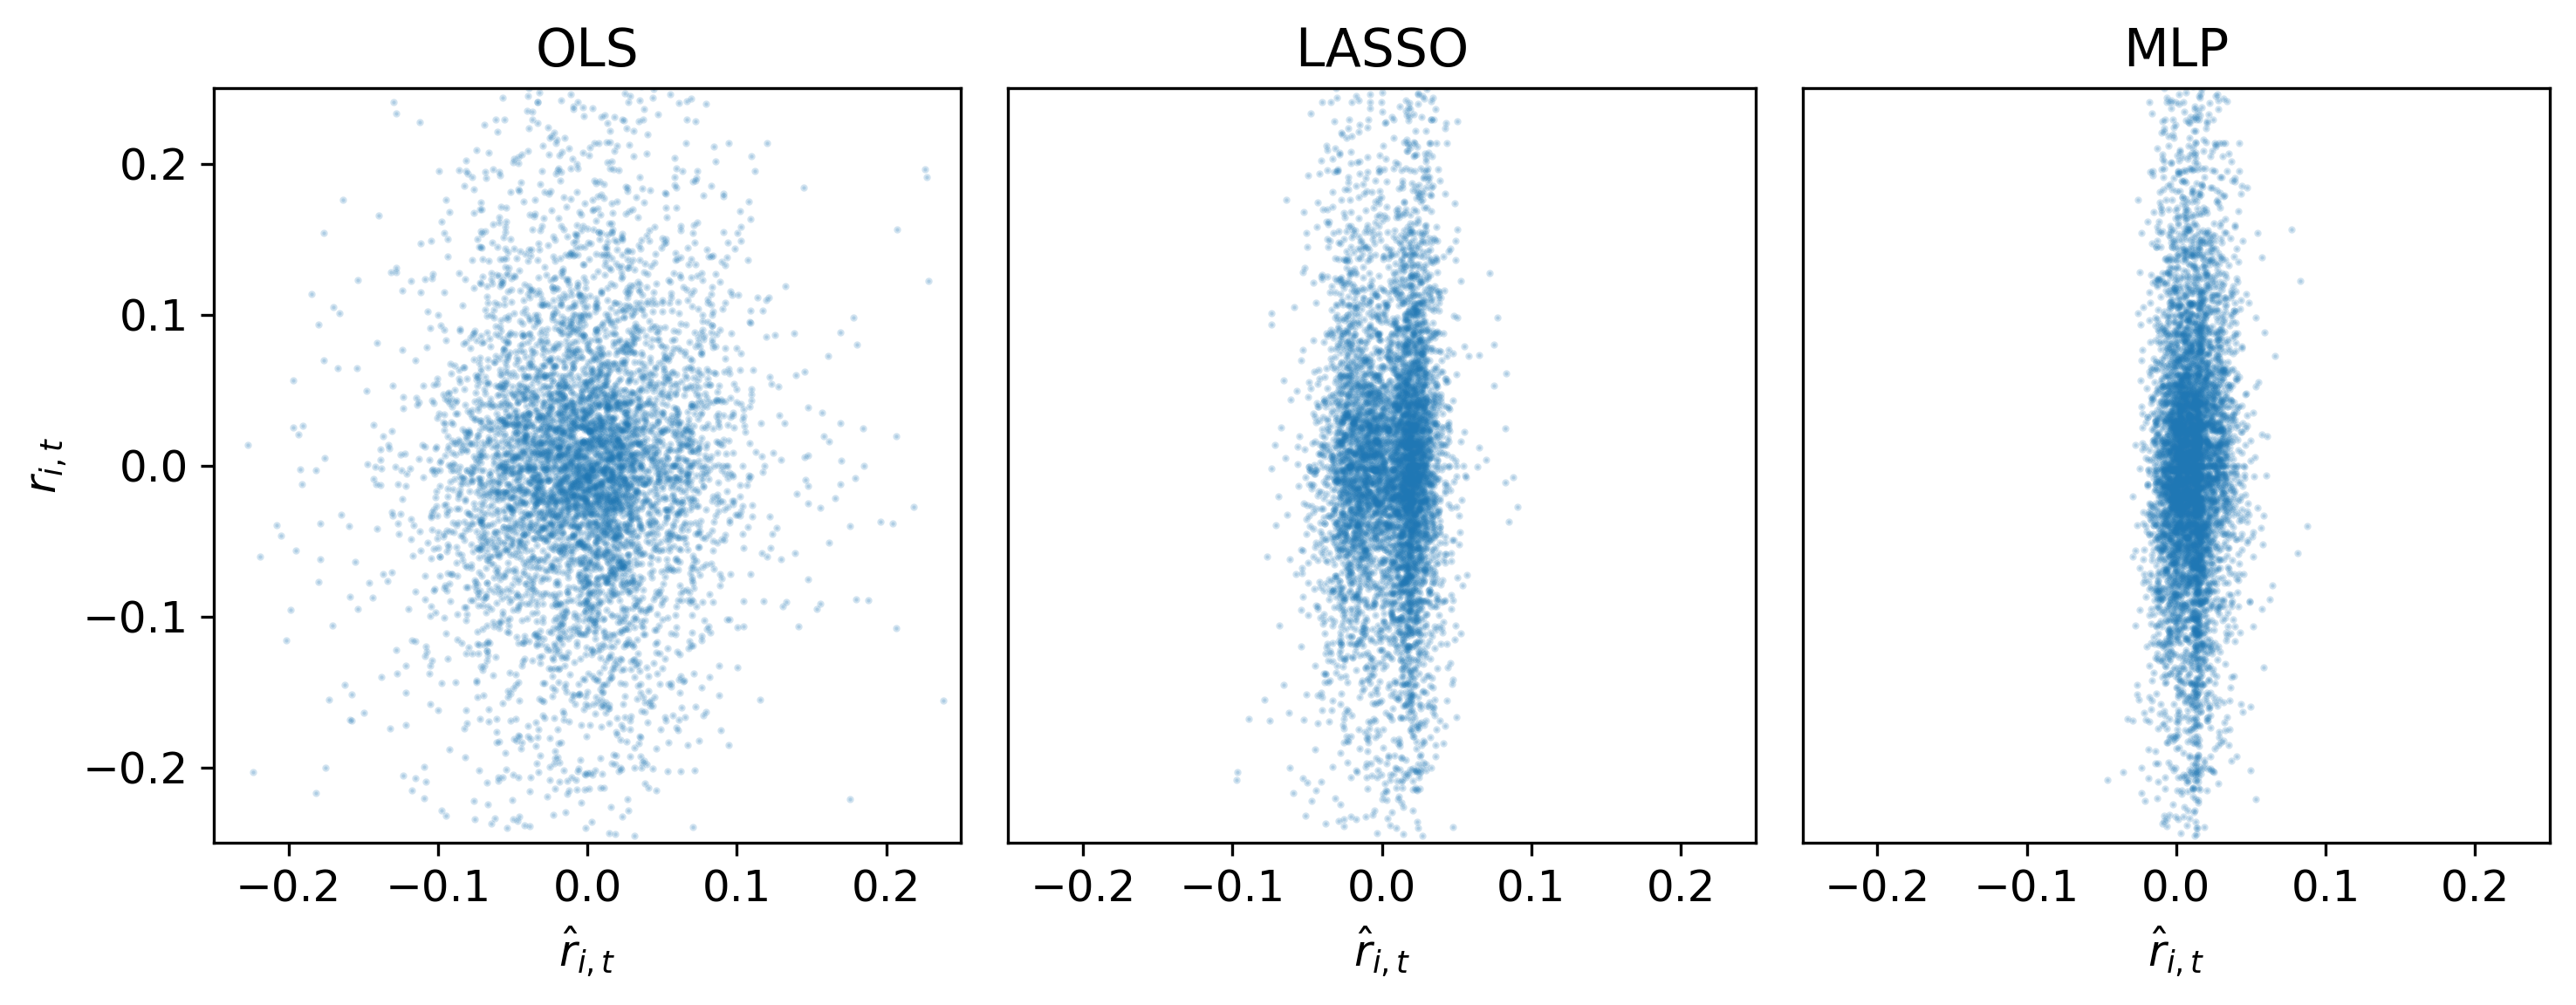

In [25]:
# plot y_true vs. y_pred in scatter
y_min, y_max = -0.25, 0.25

plt.subplot(1,3,1)
plt.scatter(all_preds['OLS'], all_preds['y_true'], alpha=0.2, s=1)
plt.ylabel('$r_{i,t}$')
plt.xlabel('$\hat{r}_{i,t}$')
# plt.yticks(np.arange(-0.3, 0.3, 0.1), fontsize=14)
plt.ylim(y_min, y_max)
plt.xlim(y_min, y_max)
plt.title('OLS')
plt.subplot(1,3,2)
plt.scatter(all_preds['LASSO'], all_preds['y_true'], alpha=0.2, s=1)
plt.xlabel('$\hat{r}_{i,t}$')
# plt.ylabel('y_pred')
plt.ylim(y_min, y_max)
plt.xlim(y_min, y_max)
plt.yticks([])    
plt.title('LASSO')
plt.subplot(1,3,3)
plt.scatter(all_preds['MLP'], all_preds['y_true'], alpha=0.2, s=1)
plt.xlabel('$\hat{r}_{i,t}$')
# plt.ylabel('y_pred')
plt.ylim(y_min, y_max)
plt.xlim(y_min, y_max)
plt.yticks([])    
plt.title('MLP')
plt.tight_layout()
plt.savefig('figs/y_true_vs_y_pred.png', dpi=300)
plt.show()
plt.close()


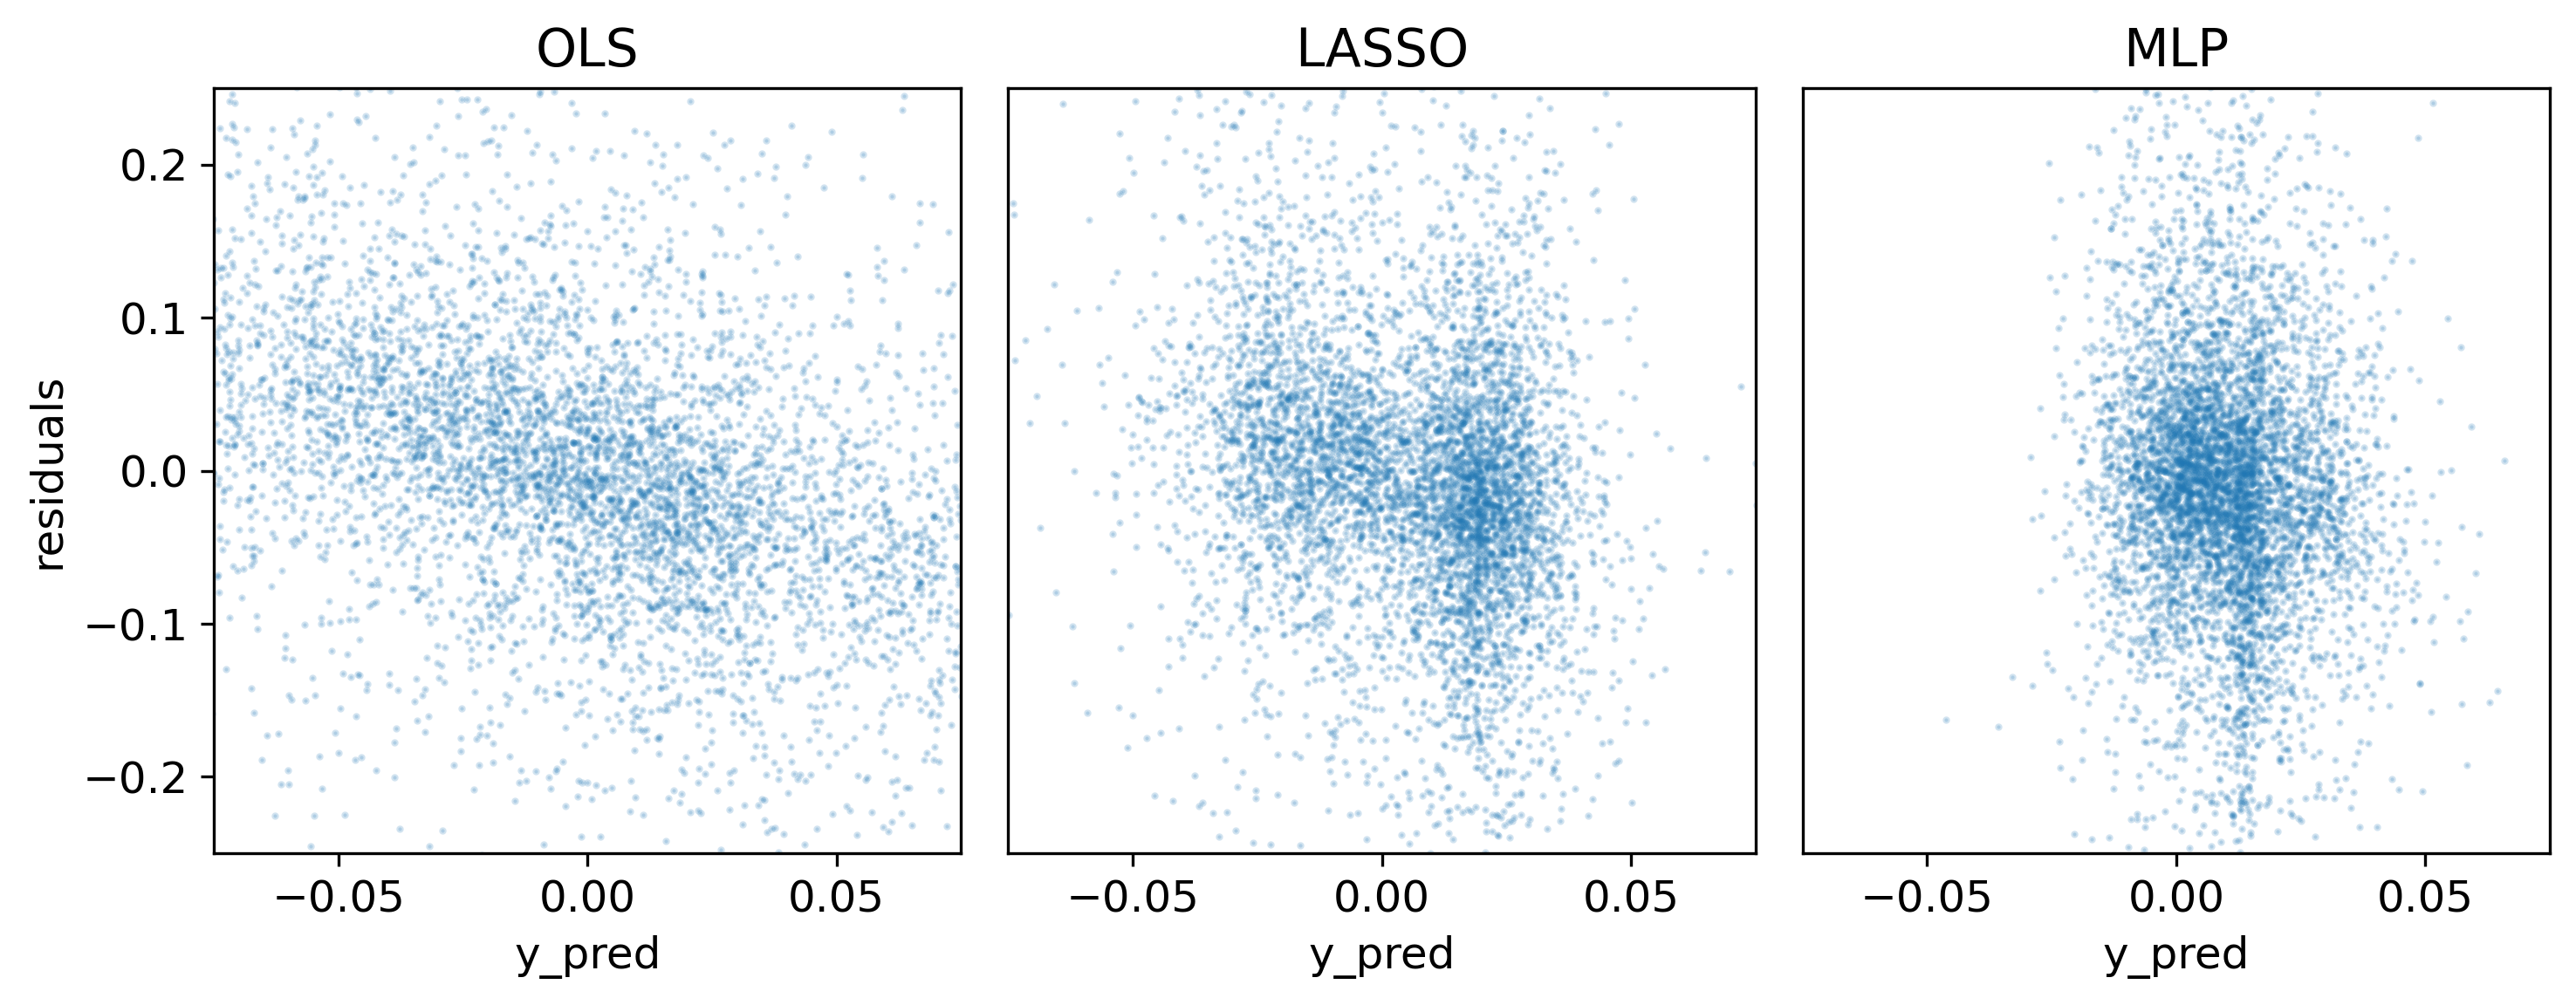

In [20]:
# plot y_true vs. y_pred in scatter
y_min, y_max = -0.25, 0.25

plt.subplot(1,3,1)
plt.scatter(all_preds['OLS'], all_preds['y_true']-all_preds['OLS'], alpha=0.2, s=1)
plt.xlabel('y_pred')
plt.ylabel('residuals')
# plt.yticks(np.arange(-0.3, 0.3, 0.1), fontsize=14)
plt.ylim(y_min, y_max)
plt.xlim(-0.075, 0.075)
plt.title('OLS')
plt.subplot(1,3,2)
plt.scatter(all_preds['LASSO'], all_preds['y_true']-all_preds['LASSO'], alpha=0.2, s=1)
plt.xlabel('y_pred')
# plt.ylabel('y_pred')
plt.ylim(y_min, y_max)
plt.xlim(-0.075, 0.075)
plt.yticks([])  
plt.title('LASSO')
plt.subplot(1,3,3)
plt.scatter(all_preds['MLP'], all_preds['y_true']-all_preds['MLP'], alpha=0.2, s=1)
plt.xlabel('y_pred')
# plt.ylabel('y_pred')
plt.ylim(y_min, y_max)
plt.xlim(-0.075, 0.075)
plt.yticks([])  
plt.title('MLP')
plt.tight_layout()
# plt.savefig('figs/y_true_vs_error.png', dpi=300)
plt.show()
plt.close()


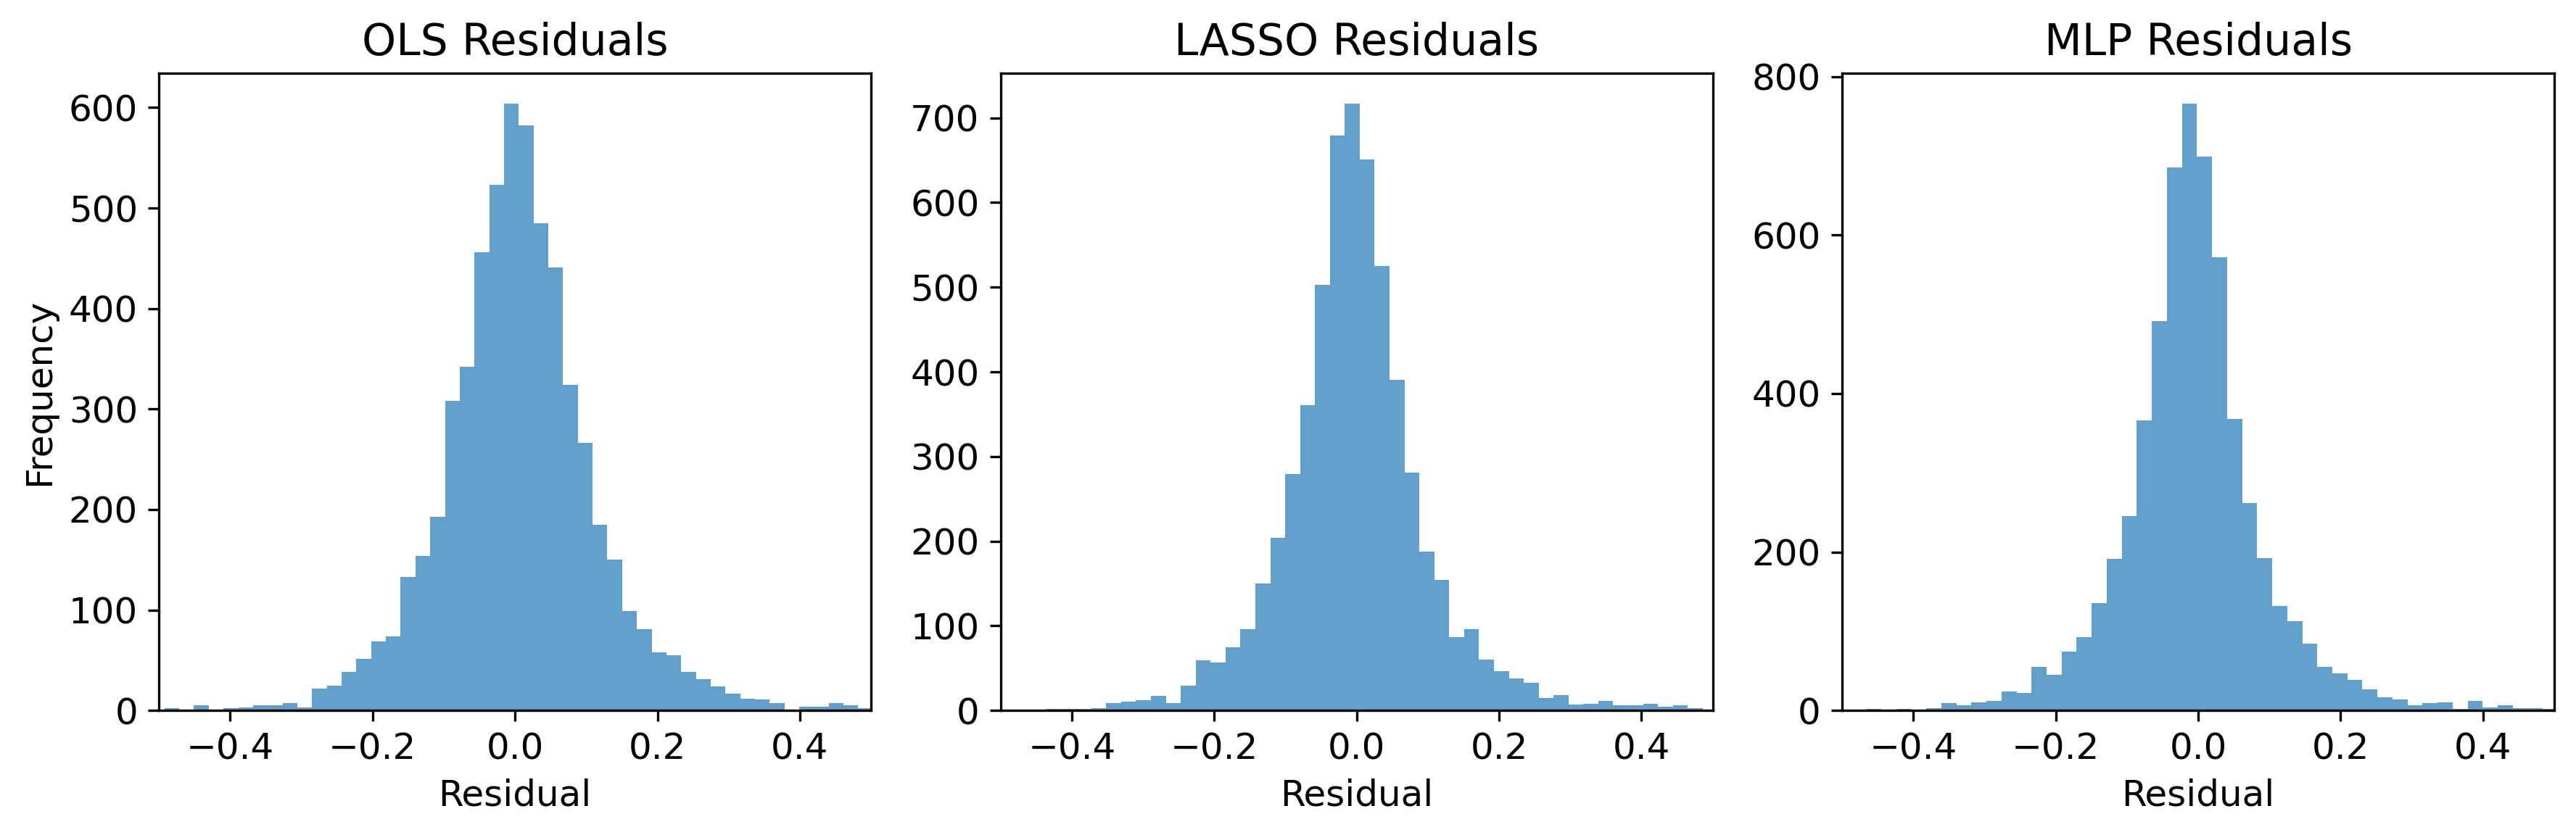

In [21]:
# define plot limits
y_min, y_max = -0.5, 0.5
bins = 500

# Compute residuals
res_ols   = all_preds['y_true'] - all_preds['OLS']
res_lasso = all_preds['y_true'] - all_preds['LASSO']
res_mlp   = all_preds['y_true'] - all_preds['MLP']

# Plot histograms
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(res_ols, bins=bins, alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('OLS Residuals')
plt.xlim(y_min, y_max)

plt.subplot(1, 3, 2)
plt.hist(res_lasso, bins=bins, alpha=0.7)
plt.xlabel('Residual')
plt.title('LASSO Residuals')
plt.xlim(y_min, y_max)

plt.subplot(1, 3, 3)
plt.hist(res_mlp, bins=bins, alpha=0.7)
plt.xlabel('Residual')
plt.title('MLP Residuals')
plt.xlim(y_min, y_max)

plt.tight_layout()
plt.show()
